# Refactorisation

In [2]:
import numpy as np
import random
import time
from datetime import datetime
from datetime import timedelta
import pandas as pd
from statistics import mean
from loguru import logger
import uuid
import json
import pytz
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from statsmodels.formula.api import ols
plt.style.use('seaborn')

### Read Data

In [10]:
# global constants
filename = '20200715-E7S2WK4HFP-br.jsonl'

def parse_file(n_lines=None):
    with open(filename) as infile:
        if n_lines is not None: # only read at most n_lines
            file_iterator = itertools.islice(infile,n_lines,n_lines+500000)
        else:
            file_iterator = infile
        all_dict = list(map(json.loads,file_iterator))
        logger.info("Loaded {} rows",len(all_dict))
        return all_dict
    
def create_frame(br_object):
    deals = br_object['Bidrequest']['imp'][0]['pmp']['deals']
    for deal in deals:
        if deal['id'] == "E7S2WK4HFP":
            price = deal['bidfloor'] 
    ts = br_object['Timestamp_status_receive_ms']/1000
    tz = pytz.timezone(br_object['Timezone'])
    record={
        'UTC_date': datetime.utcfromtimestamp(ts),
        'local_date': datetime.fromtimestamp(ts,tz=tz),
        'local_hour': datetime.fromtimestamp(ts,tz=tz).hour,
        'ts': ts,
        'TZ': br_object['Timezone'],
        'imps': br_object['Imps'],
        'CPM': price
        }
    record['price'] = (record['imps'] * record['CPM']) / 1000
    return record

In [11]:
%%time

# We have to load 6 000 000 lines
first = True
N_LINES = 0
while N_LINES < 5500000:
    if first:
        first = False
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = pd.DataFrame.from_records(records).sort_values("ts",ascending=True)
    else:
        N_LINES += 500000
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = df.append(pd.DataFrame.from_records(records).sort_values("ts",ascending=True))  

2020-08-20 12:17:37.070 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:18:03.402 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:18:30.310 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:19:09.486 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:19:42.321 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:20:41.993 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:21:50.072 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:23:24.067 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:25:24.681 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:27:38.497 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:30:12.081 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-20 12:32:56.554 | INFO     | __main__:parse_file:11 - Loaded 500000 rows


CPU times: user 4min 59s, sys: 21.9 s, total: 5min 21s
Wall time: 15min 48s


In [12]:
def win_proba(probability):
    return random.random() < probability
def delay_notif():
    if random.random() < 0.90:
        delay = random.randint(2,60)
    else:
        delay = random.randint(60,900)
    return delay

In [13]:
df['win'] = df.apply(lambda x: win_proba(0.25), axis = 1)
df['seconds_notif'] = df.apply(lambda x: delay_notif(), axis = 1)

In [3]:
df = pd.read_pickle('br_clean.pkl')
data = df[df.TZ == 'America/New_York']
data.set_index('local_date', inplace=True)
data.sort_index(inplace = True)

In [4]:
data

,UTC_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
local_date,,,,,,,,,
2020-07-07 20:00:00.042000-04:00,2020-07-08 00:00:00.042,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4
2020-07-07 20:00:00.070000-04:00,2020-07-08 00:00:00.070,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32
2020-07-07 20:00:01.305000-04:00,2020-07-08 00:00:01.305,20,1.594166e+09,America/New_York,20.371296,9,0.183342,True,38
2020-07-07 20:00:01.706000-04:00,2020-07-08 00:00:01.706,20,1.594166e+09,America/New_York,1.015774,9,0.009142,True,14
2020-07-07 20:00:01.729000-04:00,2020-07-08 00:00:01.729,20,1.594166e+09,America/New_York,2.353671,9,0.021183,True,16
...,...,...,...,...,...,...,...,...,...
2020-07-14 23:10:09.885000-04:00,2020-07-15 03:10:09.885,23,1.594783e+09,America/New_York,21.297884,9,0.191681,True,43
2020-07-14 23:10:09.885000-04:00,2020-07-15 03:10:09.885,23,1.594783e+09,America/New_York,5.075873,9,0.045683,True,46
2020-07-14 23:10:10.090000-04:00,2020-07-15 03:10:10.090,23,1.594783e+09,America/New_York,22.478413,9,0.202306,True,49


### Pacing

In [8]:
remove = data['2020-07-14']
databis = data.drop(remove.index)

In [9]:
remove =databis['2020-07-09']

In [10]:
databis = databis.drop(remove.index)

In [5]:
databis = data['2020-07-08':'2020-07-09']

In [6]:
databis

,UTC_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
local_date,,,,,,,,,
2020-07-08 00:00:02.434000-04:00,2020-07-08 04:00:02.434,0,1.594181e+09,America/New_York,5.791746,9,0.052126,True,215
2020-07-08 00:00:02.540000-04:00,2020-07-08 04:00:02.540,0,1.594181e+09,America/New_York,7.657884,9,0.068921,True,28
2020-07-08 00:00:02.895000-04:00,2020-07-08 04:00:02.895,0,1.594181e+09,America/New_York,36.899762,9,0.332098,True,43
2020-07-08 00:00:02.994000-04:00,2020-07-08 04:00:02.994,0,1.594181e+09,America/New_York,49.563413,9,0.446071,True,21
2020-07-08 00:00:04.257000-04:00,2020-07-08 04:00:04.257,0,1.594181e+09,America/New_York,2.903413,9,0.026131,True,369
...,...,...,...,...,...,...,...,...,...
2020-07-09 23:59:58.299000-04:00,2020-07-10 03:59:58.299,23,1.594354e+09,America/New_York,2.189127,9,0.019702,True,41
2020-07-09 23:59:58.833000-04:00,2020-07-10 03:59:58.833,23,1.594354e+09,America/New_York,4.056746,9,0.036511,True,58
2020-07-09 23:59:58.927000-04:00,2020-07-10 03:59:58.927,23,1.594354e+09,America/New_York,1.392857,9,0.012536,True,303


In [7]:
def gen_prop_lr(br_object):
    aggr = br_object.imps.groupby([br_object.index.date, br_object.index.weekday, br_object.index.hour]).sum()
    aggr.index.names = ['date', 'weekday', 'hour']
    aggr = aggr.reset_index()
    model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
    weekday_list = range(7)
    weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
    hour_list = list()
    for i in range(7):
        for z in range(24):
            hour_list.append(z)
    df_fitting = pd.DataFrame({'weekday': weekday_list, 'hour': hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    pattern = df_fitting.pivot_table('fitted', index=df_fitting.hour, columns=df_fitting.weekday)
    line, col = pattern.shape
    for i in range(col):
        pattern.iloc[:, i] = pattern.iloc[:, i] * 100 / pattern.iloc[:, i].sum()
    return pattern

In [8]:
def gen_prop_lr_hour(br_object):
    aggr = br_object.imps.groupby([br_object.index.date, br_object.index.hour]).sum().reset_index()
    aggr.columns = ['date', 'hour', 'imps']
    model = ols('imps ~ C(hour)', data=aggr).fit()
    hour_list = list()
    for z in range(24):
        hour_list.append(z)
    df_fitting = pd.DataFrame({'hour': hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    df_fitting.index = df_fitting.hour
    del df_fitting['hour']
    df_fitting.iloc[:, 0] = df_fitting.iloc[:, 0] * 100 / df_fitting.iloc[:, 0].sum()
    return df_fitting

In [9]:
def meta_prop(data):
    """ Give the proportion of impressions per hour. The output type depends on the input.

    :param data: a dataframe with a datetime as index
    :return: an  integer, a Serie or a Dataframe
    """
    if data.empty:
        unif = True
        without_weekday = True
        prop = 1/24
    elif set(data.index.hour.unique()) != set(range(24)):
        unif = True
        without_weekday = True
        prop = 1/24
    else:
        if set(data.index.weekday.unique()) != set(range(7)):
            unif = False
            without_weekday = True
            prop = gen_prop_lr_hour(data)
        else:
            unif = False
            without_weekday = False
            prop = gen_prop_lr(data)
    return prop, unif, without_weekday

In [10]:
def send_pending_notifications(instance_obj, pending_notif, current_ts=None):
    """ Send notifications

    :param instance_obj: instance of the algorithm class
    :param pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(pending_notif) > 0 and (pending_notif[0]['timestamp'] <= current_ts if current_ts else True):
        ev = pending_notif.pop(0)
        instance_obj.receive_notification(ev['status'], ev['br_price'])

In [11]:
class Pacing:
    """ The pacing algorithm class
    """
    def __init__(self, total_budget, start_date, end_date, timezone):
        """Class constructor"""
        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        # Fixed attributes
        self.tz = pytz.timezone(timezone)
        self.start_date = self.tz.localize(start_date)
        self.end_date = self.tz.localize(end_date)
        self.total_days = (self.end_date - self.start_date).days + 1
        self.building = list()
        # Impossible day and hour to initialize the setup
        self.day = 0
        self.total_budget = total_budget
        self.remaining_budget = self.total_budget
        self.engaged_budget = 0
        self.spent_budget = 0

    def day_reset(self, ts):
        """ Reset variables when there is a new day
        """
        day = ts.day
        month = ts.month
        year = ts.year
        remaining_days = (self.end_date - ts).days + 2   # +2 because biased calculation of days
        if not self.building:
            self.building_data = pd.DataFrame.from_records(self.building)
        else:
            self.building_data = pd.DataFrame.from_records(self.building, index='Date')
        self.current_hour = -1
        self.remaining_budget_hour = 0
        self.daily_budget = self.remaining_budget / remaining_days
        self.surplus_hour = 0
        self.BT = [0]
        self.acceleration = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                              'A': 0}]
        self.speed = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = meta_prop(self.building_data)

    def hour_reset(self, weekday):
        """ Reset budget for the following hour
        """
        self.current_hour += 1
        self.remaining_hours = 24 - self.current_hour
        # Evolutive target
        self.surplus_hour += self.remaining_budget_hour / self.remaining_hours
        if self.unif:
            self.budget_hour = (self.prop_table * self.daily_budget) + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.daily_budget + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, weekday] / 100) * self.daily_budget + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

    def gen_mean(self, mean_type):
        """ Return the average variation and speed of variation for bt
        """
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        if mean_type == 'acceleration':
            while self.acceleration[0]['ts'] < created_time:
                self.size_acceleration -= 1
                self.sum_acceleration += self.acceleration[0]['A']
                del self.acceleration[0]
            try:
                average = self.sum_acceleration / self.size_acceleration
            except ZeroDivisionError:
                average = 0
        else:
            while self.speed[0]['ts'] < created_time:
                self.size_speed -= 1
                self.sum_speed += self.speed[0]['S']
                del self.speed[0]
            try:
                average = self.sum_speed / self.size_speed
            except ZeroDivisionError:
                average = 0
        return average

    def build_data_prop(self, ts, imps):
        self.building.append({'Date': ts, 'imps': imps})

    def bt_calculation(self, average_acceleration, average_speed, remaining_time, coef=1):
        """ Return the per second budget
        """
        alpha = average_acceleration * coef
        try:
            bt = self.remaining_budget_hour * ((1 + alpha * average_speed) / remaining_time)
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        return bt

    def buying_decision(self, ts, price, imps):
        """From a BR, decide whether to buy or not

        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False

        # TS de la BR
        weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.day != day:
            self.day_reset(ts)
        self.day = day

        # Changement of hour
        while hour != self.current_hour:
            self.hour_reset(weekday)

        # Build data for proportion lr
        self.build_data_prop(ts, imps)

        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour) - datetime.timestamp(ts)

        # Calculation of bt
        average_acceleration = self.gen_mean('acceleration')
        average_speed = self.gen_mean('speed')
        bt = self.bt_calculation(average_acceleration, average_speed, remaining_time)

        # Calculation of vt and at
        self.BT.append(bt)
        vt = self.BT[-1] - self.BT[-2]
        self.speed.append({'ts': ts,
                           'S': vt})
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts': ts,
                                  'A': at})

        # Buying decision
        if (bt >= self.target) and (self.remaining_budget_hour - price) >= 0:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False
        self.remaining_budget_hour = self.budget_hour - self.spent_hour
        self.remaining_budget = self.total_budget - (self.engaged_budget + self.spent_budget)

        return buying

    def receive_notification(self, status, br_price):
        """ From a notification, take into account the status (win/lose)
        """
        if status == 'win':
            self.engaged_budget -= br_price
            self.spent_budget += br_price
        elif status == 'lose':
            self.engaged_budget -= br_price
            self.spent_hour -= br_price

In [12]:
def main(data, budget, day_start, day_end):
    logger.info(f"Start pacing on {len(data)} bid requests")
    pacing = Pacing(total_budget=budget, start_date=datetime(2020, 7, day_start), end_date=datetime(2020, 7, day_end),
                    timezone='America/New_York')
    records = list()
    pending_notifications = list()
    day = pacing.start_date.day
    for current_ts, row in data.iterrows():
        # End of the campaign ?
        if current_ts > pacing.end_date + timedelta(days=1):
            break
        # Send current notifications
        send_pending_notifications(pacing, pending_notifications, current_ts)
        if current_ts.day != day:
            day = current_ts.day
            # Send remaining notifications
            send_pending_notifications(pacing, pending_notifications)
            records[-1]['engaged'] = pacing.engaged_budget
            pacing.remaining_budget = pacing.total_budget - (pacing.engaged_budget + pacing.spent_budget)
            records[-1]['remaining'] = pacing.remaining_budget
            records[-1]['spent'] = pacing.spent_budget

        # Receive BR
        buying = pacing.buying_decision(current_ts, row['price'], row['imps'])

        # Making a decision
        if buying:
            next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            notif_id = uuid.uuid4()
            pending_notifications.append(
                {"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
            pending_notifications.sort(key=lambda x: x['timestamp'])
        record = {
            'buying': buying,
            'remaining': pacing.remaining_budget,
            'spent': pacing.spent_budget,
            'engaged': pacing.engaged_budget
        }
        records.append(record)

    # Send remaining notifications
    send_pending_notifications(pacing, pending_notifications)

    # Update last row after sending last notifications
    records[-1]['engaged'] = pacing.engaged_budget
    pacing.remaining_budget = pacing.total_budget - (pacing.engaged_budget + pacing.spent_budget)
    records[-1]['remaining'] = pacing.remaining_budget
    records[-1]['spent'] = pacing.spent_budget
    pacing_df = pd.DataFrame.from_records(records)
    new_df = pd.concat([data.reset_index(), pacing_df], axis=1, ignore_index=True)
    new_df.columns = ['local_date', 'UTC_date', 'hour', 'ts', 'TZ', 'imps', 'CPM', 'price', 'win', 'seconds_notif',
                      'buying', 'remaining', 'spent', 'engaged']
    new_df.set_index('local_date', inplace=True)
    if len(new_df) == len(data):
        logger.info(f"Successful pacing")
    else:
        logger.info(f"Failed pacing")
    return new_df

In [13]:
%%time
pacing_results = main(databis, 1000, 8, 9)

2020-08-20 16:07:21.040 | INFO     | __main__:main:2 - Start pacing on 686138 bid requests
2020-08-20 16:09:24.461 | INFO     | __main__:main:56 - Successful pacing


CPU times: user 2min 3s, sys: 239 ms, total: 2min 3s
Wall time: 2min 3s


In [14]:
pacing_results.groupby(pacing_results.index.day).tail(1)

,UTC_date,hour,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,engaged
local_date,,,,,,,,,,,,,
2020-07-08 23:59:59.259000-04:00,2020-07-09 03:59:59.259,23,1.594267e+09,America/New_York,30.677381,9,0.276096,True,24,False,500.017386,499.982614,1.595946e-16
2020-07-09 23:59:59.139000-04:00,2020-07-10 03:59:59.139,23,1.594354e+09,America/New_York,4.214881,9,0.037934,True,5,False,0.001492,999.998508,-1.110223e-15


In [17]:
sum(pacing_results.buying)*100/len(pacing_results)

1.69892936989352

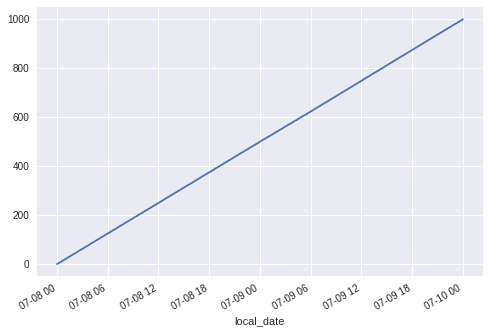

In [18]:
pacing_results.spent.plot()

Le problème vient du fait que le surplus hour est de plus en plus negatif, comme le budget par heure est déjà très faible, au bout d'un moment il devient carrément négatif (à cause du surplus hour négatif). Le budget alloué à l'heure étant négatif, la target devient négative et donc bt devient toujours au dessus de la target ce qui entraîne un achat massif en continu des br.

### Mise en difficulté - schéma de ralentissement

In [23]:
df = pd.read_pickle('br_clean.pkl')

In [39]:
data = df[df.TZ == 'America/New_York']
data.set_index('local_date', inplace=True)
data.sort_index(inplace = True)

In [40]:
data

,UTC_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
local_date,,,,,,,,,
2020-07-07 20:00:00.042000-04:00,2020-07-08 00:00:00.042,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4
2020-07-07 20:00:00.070000-04:00,2020-07-08 00:00:00.070,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32
2020-07-07 20:00:01.305000-04:00,2020-07-08 00:00:01.305,20,1.594166e+09,America/New_York,20.371296,9,0.183342,True,38
2020-07-07 20:00:01.706000-04:00,2020-07-08 00:00:01.706,20,1.594166e+09,America/New_York,1.015774,9,0.009142,True,14
2020-07-07 20:00:01.729000-04:00,2020-07-08 00:00:01.729,20,1.594166e+09,America/New_York,2.353671,9,0.021183,True,16
...,...,...,...,...,...,...,...,...,...
2020-07-14 23:10:09.885000-04:00,2020-07-15 03:10:09.885,23,1.594783e+09,America/New_York,21.297884,9,0.191681,True,43
2020-07-14 23:10:09.885000-04:00,2020-07-15 03:10:09.885,23,1.594783e+09,America/New_York,5.075873,9,0.045683,True,46
2020-07-14 23:10:10.090000-04:00,2020-07-15 03:10:10.090,23,1.594783e+09,America/New_York,22.478413,9,0.202306,True,49


In [41]:
data.loc[(data['local_hour'] == 6), 'imps'] = 1
data.loc[(data['local_hour'] == 11), 'imps'] = 1
data.loc[(data['local_hour'] == 22), 'imps'] = 1

/home/thomas/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
data['price'] = (data['imps'] * data['CPM']) / 1000

/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
data['2020-07-08 11:00']

,UTC_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
local_date,,,,,,,,,
2020-07-08 11:00:00.475000-04:00,2020-07-08 15:00:00.475,11,1.594220e+09,America/New_York,1.0,9,0.009,True,26
2020-07-08 11:00:00.575000-04:00,2020-07-08 15:00:00.575,11,1.594220e+09,America/New_York,1.0,9,0.009,True,45
2020-07-08 11:00:00.634000-04:00,2020-07-08 15:00:00.634,11,1.594220e+09,America/New_York,1.0,9,0.009,True,10
2020-07-08 11:00:00.651000-04:00,2020-07-08 15:00:00.651,11,1.594220e+09,America/New_York,1.0,9,0.009,True,147
2020-07-08 11:00:00.669000-04:00,2020-07-08 15:00:00.669,11,1.594220e+09,America/New_York,1.0,9,0.009,True,9
...,...,...,...,...,...,...,...,...,...
2020-07-08 11:00:59.379000-04:00,2020-07-08 15:00:59.379,11,1.594220e+09,America/New_York,1.0,9,0.009,True,24
2020-07-08 11:00:59.536000-04:00,2020-07-08 15:00:59.536,11,1.594220e+09,America/New_York,1.0,9,0.009,False,302
2020-07-08 11:00:59.623000-04:00,2020-07-08 15:00:59.623,11,1.594220e+09,America/New_York,1.0,9,0.009,True,8


In [49]:
remove = data['2020-07-14']

In [50]:
databis = data.drop(remove.index)

In [51]:
%%time
pacing_results = main(databis, 21000, 7, 13)

2020-08-07 15:05:13.881 | INFO     | __main__:main:2 - Start pacing on 2120390 bid requests
2020-08-07 15:13:36.422 | INFO     | __main__:main:56 - Successful pacing


CPU times: user 8min 21s, sys: 4.08 s, total: 8min 25s
Wall time: 8min 23s


In [52]:
pacing_results.groupby(pacing_results.index.day).tail(1)

,UTC_date,hour,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,engaged
local_date,,,,,,,,,,,,,
2020-07-07 23:59:59.803000-04:00,2020-07-08 03:59:59.803,23,1.594181e+09,America/New_York,8.834286,9,0.079509,True,52,True,18186.360359,2813.639641,2.892131e-14
2020-07-08 23:59:59.259000-04:00,2020-07-09 03:59:59.259,23,1.594267e+09,America/New_York,30.677381,9,0.276096,True,24,True,15153.570738,5846.429262,1.315545e-13
2020-07-09 23:59:59.139000-04:00,2020-07-10 03:59:59.139,23,1.594354e+09,America/New_York,4.214881,9,0.037934,True,5,True,12122.171295,8877.828705,1.870518e-13
2020-07-10 23:59:59.866000-04:00,2020-07-11 03:59:59.866,23,1.594440e+09,America/New_York,36.899762,9,0.332098,True,53,False,9091.732724,11908.267276,1.921518e-13
2020-07-11 23:59:58.577000-04:00,2020-07-12 03:59:58.577,23,1.594526e+09,America/New_York,5.120212,9,0.046082,True,58,True,6059.713644,14940.286356,2.352285e-13
2020-07-12 23:59:59.941000-04:00,2020-07-13 03:59:59.941,23,1.594613e+09,America/New_York,1.764974,9,0.015885,True,21,True,3027.759336,17972.240664,2.696419e-13
2020-07-13 23:59:59.206000-04:00,2020-07-14 03:59:59.206,23,1.594699e+09,America/New_York,3.081481,9,0.027733,True,344,True,0.330182,20999.669818,2.741418e-13


In [53]:
sum(pacing_results.buying)*100/len(pacing_results)

14.875895472059385

In [61]:
day = pacing_results['2020-07-13']

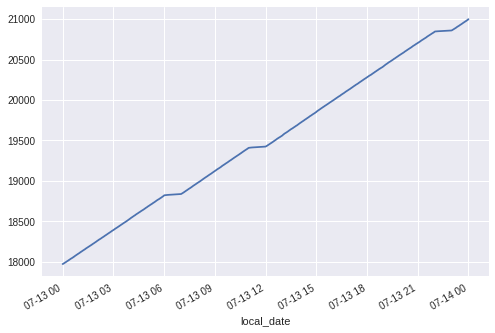

In [62]:
day.spent.plot()

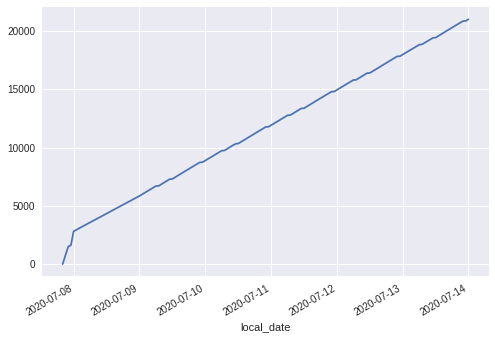

In [63]:
pacing_results.spent.plot()

### Mise en difficulté - heure biaisée sur un jour

In [2]:
df = pd.read_pickle('br_clean.pkl')

In [103]:
data = df[df.TZ == 'America/New_York']
data.set_index('local_date', inplace=True)
data.sort_index(inplace = True)

In [104]:
remove = data['2020-07-08'].between_time('06:00:01','07:00:00')

In [105]:
databis = data.drop(remove.index)

In [106]:
databis['2020-07-08 05:59:59':'2020-07-08 07:00:00']

,UTC_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
local_date,,,,,,,,,
2020-07-08 05:59:59.258000-04:00,2020-07-08 09:59:59.258,5,1.594202e+09,America/New_York,4.778201,9,0.043004,True,23
2020-07-08 05:59:59.265000-04:00,2020-07-08 09:59:59.265,5,1.594202e+09,America/New_York,11.104127,9,0.099937,True,46
2020-07-08 05:59:59.273000-04:00,2020-07-08 09:59:59.273,5,1.594202e+09,America/New_York,3.872123,9,0.034849,True,21
2020-07-08 05:59:59.425000-04:00,2020-07-08 09:59:59.425,5,1.594202e+09,America/New_York,2.974048,9,0.026766,True,47
2020-07-08 05:59:59.599000-04:00,2020-07-08 09:59:59.599,5,1.594202e+09,America/New_York,38.434709,9,0.345912,True,19
2020-07-08 05:59:59.779000-04:00,2020-07-08 09:59:59.779,5,1.594202e+09,America/New_York,3.335635,9,0.030021,True,54
2020-07-08 05:59:59.857000-04:00,2020-07-08 09:59:59.857,5,1.594202e+09,America/New_York,29.815575,9,0.268340,True,8
2020-07-08 05:59:59.863000-04:00,2020-07-08 09:59:59.863,5,1.594202e+09,America/New_York,10.751852,9,0.096767,True,60
2020-07-08 06:00:00.438000-04:00,2020-07-08 10:00:00.438,6,1.594202e+09,America/New_York,0.946429,9,0.008518,True,562


In [108]:
remove = databis['2020-07-14']
databis = databis.drop(remove.index)

In [110]:
%%time
pacing_results = main(databis, 21000, 7, 13)

2020-08-07 17:25:27.157 | INFO     | __main__:main:2 - Start pacing on 2106070 bid requests
2020-08-07 17:32:53.240 | INFO     | __main__:main:56 - Successful pacing


CPU times: user 7min 26s, sys: 3.36 s, total: 7min 29s
Wall time: 7min 27s


In [111]:
pacing_results.groupby(pacing_results.index.day).tail(1)

,UTC_date,hour,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,engaged
local_date,,,,,,,,,,,,,
2020-07-07 23:59:59.803000-04:00,2020-07-08 03:59:59.803,23,1.594181e+09,America/New_York,8.834286,9,0.079509,True,52,True,18000.812436,2999.187564,1.318182e-13
2020-07-08 23:59:59.259000-04:00,2020-07-09 03:59:59.259,23,1.594267e+09,America/New_York,30.677381,9,0.276096,True,24,True,15000.159917,5999.840083,1.462788e-13
2020-07-09 23:59:59.139000-04:00,2020-07-10 03:59:59.139,23,1.594354e+09,America/New_York,4.214881,9,0.037934,True,5,True,12000.216130,8999.783870,2.502928e-13
2020-07-10 23:59:59.866000-04:00,2020-07-11 03:59:59.866,23,1.594440e+09,America/New_York,36.899762,9,0.332098,True,53,True,8999.259385,12000.740615,2.531031e-13
2020-07-11 23:59:58.577000-04:00,2020-07-12 03:59:58.577,23,1.594526e+09,America/New_York,5.120212,9,0.046082,True,58,True,5997.991324,15002.008676,2.861947e-13
2020-07-12 23:59:59.941000-04:00,2020-07-13 03:59:59.941,23,1.594613e+09,America/New_York,1.764974,9,0.015885,True,21,True,2999.051908,18000.948092,3.143458e-13
2020-07-13 23:59:59.206000-04:00,2020-07-14 03:59:59.206,23,1.594699e+09,America/New_York,3.081481,9,0.027733,True,344,True,0.080506,20999.919494,3.228771e-13


# Intégration des Timezones

L'idée est de modifier le calcul de bt en prenant en compte les timezones. Au lieu d'allouer un budget par heure, on peut allouer un budget par heure par timezone

In [5]:
df = pd.read_pickle('br_clean.pkl')
df.set_index('UTC_date', inplace = True)
df.sort_index(inplace = True)

In [3]:
df

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
UTC_date,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32
2020-07-08 00:00:00.235,2020-07-07 20:00:00.235000-04:00,20,1.594166e+09,America/Indiana/Indianapolis,14.187500,9,0.127688,True,42
2020-07-08 00:00:00.493,2020-07-07 19:00:00.493000-05:00,19,1.594166e+09,America/Chicago,2.755000,9,0.024795,True,6
2020-07-08 00:00:00.787,2020-07-08 02:00:00.787000+02:00,2,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,35
...,...,...,...,...,...,...,...,...,...
2020-07-15 03:10:10.286,2020-07-14 20:10:10.286000-07:00,20,1.594783e+09,America/Phoenix,2.581984,9,0.023238,True,8
2020-07-15 03:10:10.384,2020-07-14 22:10:10.384000-05:00,22,1.594783e+09,America/Chicago,1.570079,9,0.014131,True,11
2020-07-15 03:10:10.558,2020-07-14 23:10:10.558000-04:00,23,1.594783e+09,America/New_York,10.327063,9,0.092944,True,22


In [4]:
data = df[df.TZ == 'America/New_York']
# data.set_index('local_date', inplace = True)
# data.sort_index(inplace = True)

In [5]:
data

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
UTC_date,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32
2020-07-08 00:00:01.305,2020-07-07 20:00:01.305000-04:00,20,1.594166e+09,America/New_York,20.371296,9,0.183342,True,38
2020-07-08 00:00:01.706,2020-07-07 20:00:01.706000-04:00,20,1.594166e+09,America/New_York,1.015774,9,0.009142,True,14
2020-07-08 00:00:01.729,2020-07-07 20:00:01.729000-04:00,20,1.594166e+09,America/New_York,2.353671,9,0.021183,True,16
...,...,...,...,...,...,...,...,...,...
2020-07-15 03:10:09.885,2020-07-14 23:10:09.885000-04:00,23,1.594783e+09,America/New_York,21.297884,9,0.191681,True,43
2020-07-15 03:10:09.885,2020-07-14 23:10:09.885000-04:00,23,1.594783e+09,America/New_York,5.075873,9,0.045683,True,46
2020-07-15 03:10:10.090,2020-07-14 23:10:10.090000-04:00,23,1.594783e+09,America/New_York,22.478413,9,0.202306,True,49


In [37]:
databis = df['2020-07-09':'2020-07-10']

In [38]:
databis

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
UTC_date,,,,,,,,,
2020-07-09 00:00:00.016,2020-07-08 19:00:00.016000-05:00,19,1.594253e+09,America/Chicago,2.030397,9,0.018274,True,5
2020-07-09 00:00:00.082,2020-07-08 20:00:00.082000-04:00,20,1.594253e+09,America/New_York,5.393254,9,0.048539,True,9
2020-07-09 00:00:00.426,2020-07-08 20:00:00.426000-04:00,20,1.594253e+09,America/New_York,4.974921,9,0.044774,True,9
2020-07-09 00:00:00.499,2020-07-08 17:00:00.499000-07:00,17,1.594253e+09,America/Los_Angeles,6.328148,9,0.056953,True,36
2020-07-09 00:00:00.534,2020-07-08 20:00:00.534000-04:00,20,1.594253e+09,America/New_York,2.554286,9,0.022989,True,8
...,...,...,...,...,...,...,...,...,...
2020-07-10 23:59:59.422,2020-07-10 16:59:59.422000-07:00,16,1.594426e+09,America/Phoenix,43.797556,9,0.394178,False,42
2020-07-10 23:59:59.507,2020-07-10 19:59:59.507000-04:00,19,1.594426e+09,America/New_York,2.438155,9,0.021943,True,51
2020-07-10 23:59:59.662,2020-07-10 18:59:59.662000-05:00,18,1.594426e+09,America/Chicago,30.932778,9,0.278395,True,54


In [36]:
databis.reset_index(inplace=True)
databis.set_index('UTC_date', inplace = True)
databis.sort_index(inplace = True)

In [39]:
prop_tz = (databis.groupby(databis['TZ']).size()/len(databis))

In [40]:
liste_tz = databis.TZ.unique().tolist()

In [41]:
print(liste_tz)
print(prop_tz)

['America/Chicago', 'America/New_York', 'America/Los_Angeles', 'Europe/Paris', 'America/Phoenix', 'Europe/London', 'America/Indiana/Indianapolis', 'America/Detroit', 'America/Denver', 'America/Boise', 'America/Kentucky/Louisville']
TZ
America/Boise                   0.004687
America/Chicago                 0.380134
America/Denver                  0.011263
America/Detroit                 0.019749
America/Indiana/Indianapolis    0.003236
America/Kentucky/Louisville     0.000986
America/Los_Angeles             0.054755
America/New_York                0.410259
America/Phoenix                 0.012265
Europe/London                   0.034075
Europe/Paris                    0.068591
dtype: float64


In [9]:
def send_pending_notifications(instance_obj, Pending_notif, tz, current_ts=None):
    """ Send notifications

    :param instance_obj: instance of the algorithm class
    :param pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(Pending_notif[tz]) > 0 and (Pending_notif[tz][0]['timestamp'] <= current_ts if current_ts else True):
        ev = Pending_notif[tz].pop(0)
        instance_obj.receive_notification(ev['status'], ev['br_price'], tz)

In [10]:
class Pacing:
    """ The pacing algorithm class
    """

    def __init__(self, total_budget, start_date, end_date, tz_list, prop_tz):
        """Class constructor"""
        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        # Fixed attributes
        self.tz_list = tz_list
        self.start_date = start_date
        self.end_date = end_date
        self.total_days = (self.end_date - self.start_date).days + 1
        self.total_budget = total_budget
        self.total_remaining_budget = self.total_budget
        self.total_spent_budget = 0
        self.BT = []

        # Attributes per tz
        self.Tz_object = pd.Series(index=self.tz_list, dtype=object)
        for tz in self.tz_list:
            self.Tz_object[tz] = pytz.timezone(tz)
        self.Days = pd.Series(index=self.tz_list, dtype=int)
        self.Current_hour = pd.Series(index=self.tz_list, dtype=int)
        self.Remaining_budget_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Total_budget_tz = prop_tz * self.total_budget
        self.Remaining_budget_tz = prop_tz * self.total_budget
        self.Daily_budget = pd.Series(index=self.tz_list, dtype=float)
        self.Surplus_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Remaining_hours = pd.Series(index=self.tz_list, dtype=int)
        self.Budget_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Target = pd.Series(index=self.tz_list, dtype=float)
        self.Spent_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Engaged_budget = pd.Series([0] * len(self.tz_list), index=self.tz_list, dtype=float)
        self.Spent_budget = pd.Series([0] * len(self.tz_list), index=self.tz_list, dtype=float)

    def day_reset(self, ts, tz):
        """ Reset variables when there is a new day
        """
        remaining_days = (self.Tz_object[tz].localize(
            self.end_date) - ts).days + 2  # +2 because biased calculation of days
        self.Current_hour[tz] = -1
        self.Remaining_budget_hour[tz] = 0
        self.Daily_budget[tz] = self.Remaining_budget_tz[tz] / remaining_days
        self.Surplus_hour[tz] = 0

    def hour_reset(self, tz):
        """ Reset budget for the following hour
        """
        self.Current_hour[tz] += 1
        self.Remaining_hours[tz] = 24 - self.Current_hour[tz]
        # Evolutive target
        self.Surplus_hour[tz] += self.Remaining_budget_hour[tz] / self.Remaining_hours[tz]
        self.Budget_hour[tz] = ((1 / 24) * self.Daily_budget[tz]) + self.Surplus_hour[tz]
        self.Target[tz] = self.Budget_hour[tz] / 3600
        self.Spent_hour[tz] = 0
        self.Remaining_budget_hour[tz] = self.Budget_hour[tz] - self.Spent_hour[tz]

    def bt_calculation(self, remaining_time, tz):
        """ Return the per second budget
        """
        try:
            bt = self.Remaining_budget_hour[tz] * (1 / remaining_time)
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        return bt

    def buying_decision(self, ts, tz, price, imps):
        """From a BR, decide whether to buy or not

        :param tz: timezone of the BR
        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False

        # TS de la BR
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.Days[tz] != day:
            self.day_reset(ts, tz)
        self.Days[tz] = day

        # Changement of hour
        while hour != self.Current_hour[tz]:
            self.hour_reset(tz)

        # Remaining time before the end of the hour
        end_hour = self.Tz_object[tz].localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour) - datetime.timestamp(ts)

        # Calculation of bt
        self.bt = self.bt_calculation(remaining_time, tz)
        self.BT.append(self.bt)

        # Buying decision
        if (self.bt >= self.Target[tz]) and (self.Remaining_budget_hour[tz] - price) >= 0:
            buying = True
            self.Engaged_budget[tz] += price
            self.Spent_hour[tz] += price
        else:
            buying = False
        self.Remaining_budget_hour[tz] = self.Budget_hour[tz] - self.Spent_hour[tz]
        self.Remaining_budget_tz[tz] = self.Total_budget_tz[tz] - (self.Engaged_budget[tz] + self.Spent_budget[tz])
        return buying

    def receive_notification(self, status, br_price, tz):
        """ From a notification, take into account the status (win/lose)
        """
        if status == 'win':
            self.Engaged_budget[tz] -= br_price
            self.Spent_budget[tz] += br_price
        elif status == 'lose':
            self.Engaged_budget[tz] -= br_price
            self.Spent_hour[tz] -= br_price

In [12]:
def main(data, budget, day_start, day_end, tz_list, prop_tz):
    logger.info(f"Start pacing on {len(data)} bid requests")
    pacing = Pacing(total_budget=budget, start_date=datetime(2020, 7, day_start), end_date=datetime(2020, 7, day_end),
                    tz_list=tz_list, prop_tz=prop_tz)
    records = list()
    Pending_notifications = pd.Series(index=tz_list, dtype=object)
    for tz in tz_list:
        Pending_notifications[tz] = []
    Day = pd.Series(index=tz_list, dtype=int)
    Finish = pd.Series(False, index=tz_list)
    for current_ts, row in data.iterrows():
        tz = row['TZ']
        ts = row['local_date']

        # If a campaign has finished just pass
        if Finish[tz]:
            record = {
                'current_tz': tz,
                'buying': np.nan,
                'remaining_tz': np.nan,
                'spent_tz': np.nan,
                'engaged_tz': np.nan
            }
            records.append(record)
            continue

        # Before the campaign?
        if ts < pytz.timezone(tz).localize(pacing.start_date):
            record = {
                'current_tz': tz,
                'buying': np.nan,
                'remaining_tz': np.nan,
                'spent_tz': np.nan,
                'engaged_tz': np.nan
            }
            records.append(record)
            continue

        # End of the campaign?
        campaign_limit = pytz.timezone(tz).localize(pacing.end_date + timedelta(days=1))
        if ts > campaign_limit:
            send_pending_notifications(pacing, Pending_notifications, tz)
            # modify records
            last = [idx for idx, element in enumerate(records) if element['current_tz'] == tz]
            records[last[-1]]['engaged_tz'] = pacing.Engaged_budget[tz]
            pacing.Remaining_budget_tz[tz] = pacing.Total_budget_tz[tz] - (pacing.Engaged_budget[tz] +
                                                                           pacing.Spent_budget[tz])
            records[last[-1]]['remaining_tz'] = pacing.Remaining_budget_tz[tz]
            records[last[-1]]['spent_tz'] = pacing.Spent_budget[tz]
            record = {
                'current_tz': tz,
                'buying': np.nan,
                'remaining_tz': np.nan,
                'spent_tz': np.nan,
                'engaged_tz': np.nan
            }
            records.append(record)
            # Set to finish status
            Finish[tz] = True
            continue

        # Set day for the first time
        if Day[tz] == 0:
            Day[tz] = ts.day

        # Send current notifications
        send_pending_notifications(pacing, Pending_notifications, tz, ts)
        if ts.day != Day[tz]:
            Day[tz] = ts.day
            # Send remaining notifications
            send_pending_notifications(pacing, Pending_notifications, tz)
            # modify records
            last = [idx for idx, element in enumerate(records) if element['current_tz'] == tz]
            records[last[-1]]['engaged_tz'] = pacing.Engaged_budget[tz]
            pacing.Remaining_budget_tz[tz] = pacing.Total_budget_tz[tz] - (pacing.Engaged_budget[tz] +
                                                                           pacing.Spent_budget[tz])
            records[last[-1]]['remaining_tz'] = pacing.Remaining_budget_tz[tz]
            records[last[-1]]['spent_tz'] = pacing.Spent_budget[tz]

        # Receive BR
        buying = pacing.buying_decision(ts, tz, row['price'], row['imps'])

        # Making a decision
        if buying:
            next_notif_ts = ts + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            notif_id = uuid.uuid4()
            Pending_notifications[tz].append(
                {"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
            Pending_notifications[tz].sort(key=lambda x: x['timestamp'])
        record = {
            'current_tz': tz,
            'buying': buying,
            'remaining_tz': pacing.Remaining_budget_tz[tz],
            'spent_tz': pacing.Spent_budget[tz],
            'engaged_tz': pacing.Engaged_budget[tz]
        }
        records.append(record)
    pacing_df = pd.DataFrame.from_records(records)
    new_df = pd.concat([data.reset_index(), pacing_df], axis=1, ignore_index=True)
    new_df.columns = ['UTC_date', 'local_date', 'hour', 'ts', 'TZ', 'imps', 'CPM', 'price', 'win', 'seconds_notif',
                      'current_tz', 'buying', 'remaining_tz', 'spent_tz', 'engaged_tz']
    new_df.set_index('UTC_date', inplace=True)
    if len(new_df) == len(data):
        logger.info(f"Successful pacing")
    else:
        logger.info(f"Failed pacing")
    return new_df

In [13]:
%%time
pacing_results = main(databis, 5000, 9, 9, liste_tz, prop_tz)

2020-08-18 17:46:38.194 | INFO     | __main__:main:2 - Start pacing on 1670726 bid requests
2020-08-18 17:55:50.078 | INFO     | __main__:main:105 - Successful pacing


CPU times: user 9min 10s, sys: 1.34 s, total: 9min 12s
Wall time: 9min 12s


In [14]:
pacing_results

,local_date,hour,ts,TZ,imps,CPM,price,win,seconds_notif,current_tz,buying,remaining_tz,spent_tz,engaged_tz
UTC_date,,,,,,,,,,,,,,
2020-07-09 00:00:00.016,2020-07-08 19:00:00.016000-05:00,19,1.594253e+09,America/Chicago,2.030397,9,0.018274,True,5,America/Chicago,NaN,NaN,NaN,NaN
2020-07-09 00:00:00.082,2020-07-08 20:00:00.082000-04:00,20,1.594253e+09,America/New_York,5.393254,9,0.048539,True,9,America/New_York,NaN,NaN,NaN,NaN
2020-07-09 00:00:00.426,2020-07-08 20:00:00.426000-04:00,20,1.594253e+09,America/New_York,4.974921,9,0.044774,True,9,America/New_York,NaN,NaN,NaN,NaN
2020-07-09 00:00:00.499,2020-07-08 17:00:00.499000-07:00,17,1.594253e+09,America/Los_Angeles,6.328148,9,0.056953,True,36,America/Los_Angeles,NaN,NaN,NaN,NaN
2020-07-09 00:00:00.534,2020-07-08 20:00:00.534000-04:00,20,1.594253e+09,America/New_York,2.554286,9,0.022989,True,8,America/New_York,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10 23:59:59.422,2020-07-10 16:59:59.422000-07:00,16,1.594426e+09,America/Phoenix,43.797556,9,0.394178,False,42,America/Phoenix,NaN,NaN,NaN,NaN
2020-07-10 23:59:59.507,2020-07-10 19:59:59.507000-04:00,19,1.594426e+09,America/New_York,2.438155,9,0.021943,True,51,America/New_York,NaN,NaN,NaN,NaN
2020-07-10 23:59:59.662,2020-07-10 18:59:59.662000-05:00,18,1.594426e+09,America/Chicago,30.932778,9,0.278395,True,54,America/Chicago,NaN,NaN,NaN,NaN


In [15]:
res = pacing_results.dropna()

In [16]:
res

,local_date,hour,ts,TZ,imps,CPM,price,win,seconds_notif,current_tz,buying,remaining_tz,spent_tz,engaged_tz
UTC_date,,,,,,,,,,,,,,
2020-07-09 00:00:00.889,2020-07-09 02:00:00.889000+02:00,2,1.594253e+09,Europe/Paris,1.000000,6,0.006000,True,54,Europe/Paris,True,342.949697,0.000000,6.000000e-03
2020-07-09 00:00:01.891,2020-07-09 02:00:01.891000+02:00,2,1.594253e+09,Europe/Paris,1.000000,6,0.006000,True,54,Europe/Paris,True,342.943697,0.000000,1.200000e-02
2020-07-09 00:00:02.895,2020-07-09 02:00:02.895000+02:00,2,1.594253e+09,Europe/Paris,1.000000,6,0.006000,True,44,Europe/Paris,True,342.937697,0.000000,1.800000e-02
2020-07-09 00:00:03.896,2020-07-09 02:00:03.896000+02:00,2,1.594253e+09,Europe/Paris,1.000000,6,0.006000,True,225,Europe/Paris,False,342.937697,0.000000,1.800000e-02
2020-07-09 00:00:04.898,2020-07-09 01:00:04.898000+01:00,1,1.594253e+09,Europe/London,1.000000,6,0.006000,True,19,Europe/London,True,170.369035,0.000000,6.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10 06:59:56.051,2020-07-09 23:59:56.051000-07:00,23,1.594364e+09,America/Los_Angeles,5.069074,9,0.045622,True,58,America/Los_Angeles,False,0.041470,273.689329,4.239810e-02
2020-07-10 06:59:57.363,2020-07-09 23:59:57.363000-07:00,23,1.594364e+09,America/Los_Angeles,73.062963,9,0.657567,True,361,America/Los_Angeles,False,0.041470,273.689329,4.239810e-02
2020-07-10 06:59:57.668,2020-07-09 23:59:57.668000-07:00,23,1.594364e+09,America/Los_Angeles,75.718624,9,0.681468,True,6,America/Los_Angeles,False,0.041470,273.689329,4.239810e-02


In [17]:
sum(res['TZ'] != res['current_tz'])

0

In [18]:
res.groupby(res['TZ']).spent_tz.tail(1).sum()

4940.5714605268695

/home/thomas/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


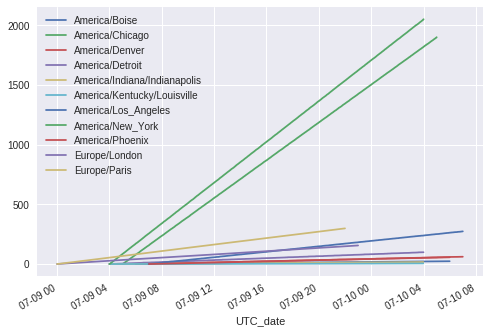

In [22]:
res.groupby(res['TZ']).spent_tz.plot()
plt.legend()

In [26]:
res.groupby(res['TZ']).tail(1)

,local_date,hour,ts,TZ,imps,CPM,price,win,seconds_notif,current_tz,buying,remaining_tz,spent_tz,engaged_tz
UTC_date,,,,,,,,,,,,,,
2020-07-09 21:59:59.212,2020-07-09 23:59:59.212000+02:00,23,1.594332e+09,Europe/Paris,1.000000,6,0.006000,True,695,Europe/Paris,True,44.149697,298.806000,-3.989864e-17
2020-07-09 22:59:59.086,2020-07-09 23:59:59.086000+01:00,23,1.594336e+09,Europe/London,1.000000,6,0.006000,True,30,Europe/London,True,14.843035,155.532000,-3.989864e-17
2020-07-10 03:59:13.253,2020-07-09 23:59:13.253000-04:00,23,1.594354e+09,America/Kentucky/Louisville,12.746984,9,0.114723,True,28,America/Kentucky/Louisville,False,0.027771,4.904216,0.000000e+00
2020-07-10 03:59:15.104,2020-07-09 23:59:15.104000-04:00,23,1.594354e+09,America/Indiana/Indianapolis,13.298280,9,0.119685,True,41,America/Indiana/Indianapolis,False,0.031319,16.147277,0.000000e+00
2020-07-10 03:59:53.800,2020-07-09 23:59:53.800000-04:00,23,1.594354e+09,America/Detroit,1.462963,9,0.013167,True,57,America/Detroit,True,0.105510,98.641981,6.730727e-16
2020-07-10 03:59:59.139,2020-07-09 23:59:59.139000-04:00,23,1.594354e+09,America/New_York,4.214881,9,0.037934,True,5,America/New_York,False,0.063182,2051.230686,1.974809e-14
2020-07-10 04:59:59.508,2020-07-09 23:59:59.508000-05:00,23,1.594357e+09,America/Chicago,3.563492,9,0.032071,True,59,America/Chicago,False,0.010953,1900.659773,4.193521e-14
2020-07-10 05:59:45.669,2020-07-09 23:59:45.669000-06:00,23,1.594361e+09,America/Boise,3.363810,9,0.030274,True,54,America/Boise,False,0.010019,23.422908,-2.949030e-17
2020-07-10 05:59:51.783,2020-07-09 23:59:51.783000-06:00,23,1.594361e+09,America/Denver,1.821825,9,0.016396,True,28,America/Denver,False,0.006647,56.310188,-1.977585e-16


# Improve Timezone algorithm

In [27]:
records = []
for i in range(24 * 2):
    records.append(
        {'date': datetime(2020, 8, 4, 0, 59, 59) + timedelta(hours=i),
         'imps': 100}
    )
data = pd.DataFrame.from_records(records, index='date')

In [12]:
all_df = pd.Series(index=liste_tz, dtype=object)
for tz in liste_tz:
    all_df[tz] = pd.DataFrame()

In [13]:
all_df[]

America/Chicago                 Empty DataFrame
Columns: []
Index: []
America/New_York                Empty DataFrame
Columns: []
Index: []
America/Los_Angeles             Empty DataFrame
Columns: []
Index: []
Europe/Paris                    Empty DataFrame
Columns: []
Index: []
America/Phoenix                 Empty DataFrame
Columns: []
Index: []
Europe/London                   Empty DataFrame
Columns: []
Index: []
America/Indiana/Indianapolis    Empty DataFrame
Columns: []
Index: []
America/Detroit                 Empty DataFrame
Columns: []
Index: []
America/Denver                  Empty DataFrame
Columns: []
Index: []
America/Boise                   Empty DataFrame
Columns: []
Index: []
America/Kentucky/Louisville     Empty DataFrame
Columns: []
Index: []
dtype: object

In [28]:
test, unif, ww = meta_prop(data)

In [29]:
test

,fitted
hour,
0,4.166667
1,4.166667
2,4.166667
3,4.166667
4,4.166667
5,4.166667
6,4.166667
7,4.166667
8,4.166667


In [30]:
all_df['America/Chicago'] = test

In [34]:
all_df['America/Chicago'].iloc[6,0] / 100

0.04166666666666667

In [42]:
def gen_prop_lr(br_object):
    aggr = br_object.imps.groupby([br_object.index.date, br_object.index.weekday, br_object.index.hour]).sum()
    aggr.index.names = ['date', 'weekday', 'hour']
    aggr = aggr.reset_index()
    model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
    weekday_list = range(7)
    weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
    hour_list = list()
    for i in range(7):
        for z in range(24):
            hour_list.append(z)
    df_fitting = pd.DataFrame({'weekday': weekday_list, 'hour': hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    pattern = df_fitting.pivot_table('fitted', index=df_fitting.hour, columns=df_fitting.weekday)
    line, col = pattern.shape
    for i in range(col):
        pattern.iloc[:, i] = pattern.iloc[:, i] * 100 / pattern.iloc[:, i].sum()
    return pattern

In [43]:
def gen_prop_lr_hour(br_object):
    aggr = br_object.imps.groupby([br_object.index.date, br_object.index.hour]).sum().reset_index()
    aggr.columns = ['date', 'hour', 'imps']
    model = ols('imps ~ C(hour)', data=aggr).fit()
    hour_list = list()
    for z in range(24):
        hour_list.append(z)
    df_fitting = pd.DataFrame({'hour': hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    df_fitting.index = df_fitting.hour
    del df_fitting['hour']
    df_fitting.iloc[:, 0] = df_fitting.iloc[:, 0] * 100 / df_fitting.iloc[:, 0].sum()
    return df_fitting


In [44]:
def meta_prop(data):
    """ Give the proportion of impressions per hour. The output type depends on the input.

    :param data: a dataframe with a datetime as index
    :return: an  integer, a Serie or a Dataframe
    """
    if data.empty:
        unif = True
        without_weekday = True
        prop = 1/24
    elif set(data.index.hour.unique()) != set(range(24)):
        unif = True
        without_weekday = True
        prop = 1/24
    else:
        if set(data.index.weekday.unique()) != set(range(7)):
            unif = False
            without_weekday = True
            prop = gen_prop_lr_hour(data)
        else:
            unif = False
            without_weekday = False
            prop = gen_prop_lr(data)
    return prop, unif, without_weekday

In [45]:
def send_pending_notifications(instance_obj, Pending_notif, tz, current_ts=None):
    """ Send notifications

    :param tz: Timezone object
    :param instance_obj: instance of the algorithm class
    :param Pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(Pending_notif[tz]) > 0 and (Pending_notif[tz][0]['timestamp'] <= current_ts if current_ts else True):
        ev = Pending_notif[tz].pop(0)
        instance_obj.receive_notification(ev['status'], ev['br_price'], tz)

In [49]:
class Pacing:
    """ The pacing algorithm class
    """

    def __init__(self, total_budget, start_date, end_date, tz_list, prop_tz):
        """Class constructor"""
        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        # Fixed attributes
        self.tz_list = tz_list
        self.start_date = start_date
        self.end_date = end_date
        self.total_days = (self.end_date - self.start_date).days + 1
        self.total_budget = total_budget
        self.total_remaining_budget = self.total_budget
        self.total_spent_budget = 0
        self.BT = []

        # Attributes per tz
        self.Tz_object = pd.Series(index=self.tz_list, dtype=object)
        for tz in self.tz_list:
            self.Tz_object[tz] = pytz.timezone(tz)
        self.Days = pd.Series(index=self.tz_list, dtype=int)
        self.Current_hour = pd.Series(index=self.tz_list, dtype=int)
        self.Remaining_budget_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Total_budget_tz = prop_tz * self.total_budget
        self.Remaining_budget_tz = prop_tz * self.total_budget
        self.Daily_budget = pd.Series(index=self.tz_list, dtype=float)
        self.Surplus_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Remaining_hours = pd.Series(index=self.tz_list, dtype=int)
        self.Budget_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Target = pd.Series(index=self.tz_list, dtype=float)
        self.Spent_hour = pd.Series(index=self.tz_list, dtype=float)
        self.Engaged_budget = pd.Series([0] * len(self.tz_list), index=self.tz_list, dtype=float)
        self.Spent_budget = pd.Series([0] * len(self.tz_list), index=self.tz_list, dtype=float)
        self.Building = pd.Series(index=tz_list, dtype=object)
        for tz in tz_list:
            self.Building[tz] = []
        self.Building_data = pd.Series(index=tz_list, dtype=object)
        for tz in tz_list:
            self.Building[tz] = pd.DataFrame()
        self.Prop_table = pd.Series(index=tz_list, dtype=object)
        for tz in tz_list:
            self.Prop_table[tz] = pd.DataFrame()
        self.Unif = pd.Series(True, index=tz_list)
        self.Without_weekday = pd.Series(True, index=tz_list)

    def day_reset(self, ts, tz):
        """ Reset variables when there is a new day
        """
        remaining_days = (self.Tz_object[tz].localize(
            self.end_date) - ts).days + 2  # +2 because biased calculation of days
        if not self.Building[tz]:
            self.Building_data[tz] = pd.DataFrame.from_records(self.Building[tz])
        else:
            self.Building_data[tz] = pd.DataFrame.from_records(self.Building[tz], index='Date')
        self.Current_hour[tz] = -1
        self.Remaining_budget_hour[tz] = 0
        self.Daily_budget[tz] = self.Remaining_budget_tz[tz] / remaining_days
        self.Surplus_hour[tz] = 0
        self.Prop_table[tz], self.Unif[tz], self.Without_weekday[tz] = meta_prop(
            self.Building_data[tz])

    def hour_reset(self, tz, weekday):
        """ Reset budget for the following hour
        """
        self.Current_hour[tz] += 1
        self.Remaining_hours[tz] = 24 - self.Current_hour[tz]
        # Evolutive target
        self.Surplus_hour[tz] += self.Remaining_budget_hour[tz] / self.Remaining_hours[tz]
        if self.Unif[tz]:
            self.Budget_hour[tz] = (self.Prop_table[tz] * self.Daily_budget[tz]) + self.Surplus_hour[tz]
        elif self.Without_weekday[tz] and not self.Unif[tz]:
            self.Budget_hour[tz] = (self.Prop_table[tz].iloc[
                                    self.Current_hour[tz], 0] / 100) * self.Daily_budget[tz] + self.Surplus_hour[tz]
        else:
            self.Budget_hour[tz] = (self.Prop_table[tz].iloc[
                                    self.Current_hour[tz], weekday] / 100) * self.Daily_budget[tz] + self.Surplus_hour[tz]
        self.Target[tz] = self.Budget_hour[tz] / 3600
        self.Spent_hour[tz] = 0
        self.Remaining_budget_hour[tz] = self.Budget_hour[tz] - self.Spent_hour[tz]
    
    def build_data_prop(self, tz, ts, imps):
        self.Building[tz].append({'Date': ts, 'imps': imps})

    def bt_calculation(self, remaining_time, tz):
        """ Return the per second budget
        """
        try:
            bt = self.Remaining_budget_hour[tz] * (1 / remaining_time)
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        return bt

    def buying_decision(self, ts, tz, price, imps):
        """From a BR, decide whether to buy or not

        :param tz: timezone of the BR
        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False

        # TS de la BR
        weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.Days[tz] != day:
            self.day_reset(ts, tz)
        self.Days[tz] = day

        # Changement of hour
        while hour != self.Current_hour[tz]:
            self.hour_reset(tz, weekday)
        
        # Build data for proportion lr
        self.build_data_prop(tz, ts, imps)
        
        # Remaining time before the end of the hour
        end_hour = self.Tz_object[tz].localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour) - datetime.timestamp(ts)

        # Calculation of bt
        self.bt = self.bt_calculation(remaining_time, tz)
        self.BT.append(self.bt)

        # Buying decision
        if (self.bt >= self.Target[tz]) and (self.Remaining_budget_hour[tz] - price) >= 0:
            buying = True
            self.Engaged_budget[tz] += price
            self.Spent_hour[tz] += price
        else:
            buying = False
        self.Remaining_budget_hour[tz] = self.Budget_hour[tz] - self.Spent_hour[tz]
        self.Remaining_budget_tz[tz] = self.Total_budget_tz[tz] - (self.Engaged_budget[tz] + self.Spent_budget[tz])
        return buying

    def receive_notification(self, status, br_price, tz):
        """ From a notification, take into account the status (win/lose)
        """
        if status == 'win':
            self.Engaged_budget[tz] -= br_price
            self.Spent_budget[tz] += br_price
        elif status == 'lose':
            self.Engaged_budget[tz] -= br_price
            self.Spent_hour[tz] -= br_price

In [50]:
def main(data, budget, day_start, day_end, tz_list, prop_tz):
    logger.info(f"Start pacing on {len(data)} bid requests")
    pacing = Pacing(total_budget=budget, start_date=datetime(2020, 7, day_start), end_date=datetime(2020, 7, day_end),
                    tz_list=tz_list, prop_tz=prop_tz)
    records = list()
    Pending_notifications = pd.Series(index=tz_list, dtype=object)
    for tz in tz_list:
        Pending_notifications[tz] = []
    Day = pd.Series(index=tz_list, dtype=int)
    Finish = pd.Series(False, index=tz_list)
    for current_ts, row in data.iterrows():
        tz = row['TZ']
        ts = row['local_date']

        # If a campaign has finished just pass
        if Finish[tz]:
            record = {
                'current_tz': tz,
                'buying': np.nan,
                'remaining_tz': np.nan,
                'spent_tz': np.nan,
                'engaged_tz': np.nan
            }
            records.append(record)
            continue

        # Before the campaign?
        if ts < pytz.timezone(tz).localize(pacing.start_date):
            record = {
                'current_tz': tz,
                'buying': np.nan,
                'remaining_tz': np.nan,
                'spent_tz': np.nan,
                'engaged_tz': np.nan
            }
            records.append(record)
            continue

        # End of the campaign?
        campaign_limit = pytz.timezone(tz).localize(pacing.end_date + timedelta(days=1))
        if ts > campaign_limit:
            send_pending_notifications(pacing, Pending_notifications, tz)
            # modify records
            last = [idx for idx, element in enumerate(records) if element['current_tz'] == tz]
            records[last[-1]]['engaged_tz'] = pacing.Engaged_budget[tz]
            pacing.Remaining_budget_tz[tz] = pacing.Total_budget_tz[tz] - (pacing.Engaged_budget[tz] +
                                                                           pacing.Spent_budget[tz])
            records[last[-1]]['remaining_tz'] = pacing.Remaining_budget_tz[tz]
            records[last[-1]]['spent_tz'] = pacing.Spent_budget[tz]
            record = {
                'current_tz': tz,
                'buying': np.nan,
                'remaining_tz': np.nan,
                'spent_tz': np.nan,
                'engaged_tz': np.nan
            }
            records.append(record)
            # Set to finish status
            Finish[tz] = True
            continue

        # Set day for the first time
        if Day[tz] == 0:
            Day[tz] = ts.day

        # Send current notifications
        send_pending_notifications(pacing, Pending_notifications, tz, ts)
        if ts.day != Day[tz]:
            Day[tz] = ts.day
            # Send remaining notifications
            send_pending_notifications(pacing, Pending_notifications, tz)
            # modify records
            last = [idx for idx, element in enumerate(records) if element['current_tz'] == tz]
            records[last[-1]]['engaged_tz'] = pacing.Engaged_budget[tz]
            pacing.Remaining_budget_tz[tz] = pacing.Total_budget_tz[tz] - (pacing.Engaged_budget[tz] +
                                                                           pacing.Spent_budget[tz])
            records[last[-1]]['remaining_tz'] = pacing.Remaining_budget_tz[tz]
            records[last[-1]]['spent_tz'] = pacing.Spent_budget[tz]

        # Receive BR
        buying = pacing.buying_decision(ts, tz, row['price'], row['imps'])

        # Making a decision
        if buying:
            next_notif_ts = ts + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            notif_id = uuid.uuid4()
            Pending_notifications[tz].append(
                {"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
            Pending_notifications[tz].sort(key=lambda x: x['timestamp'])
        record = {
            'current_tz': tz,
            'buying': buying,
            'remaining_tz': pacing.Remaining_budget_tz[tz],
            'spent_tz': pacing.Spent_budget[tz],
            'engaged_tz': pacing.Engaged_budget[tz]
        }
        records.append(record)
    pacing_df = pd.DataFrame.from_records(records)
    new_df = pd.concat([data.reset_index(), pacing_df], axis=1, ignore_index=True)
    new_df.columns = ['UTC_date', 'local_date', 'hour', 'ts', 'TZ', 'imps', 'CPM', 'price', 'win', 'seconds_notif',
                      'current_tz', 'buying', 'remaining_tz', 'spent_tz', 'engaged_tz']
    new_df.set_index('UTC_date', inplace=True)
    if len(new_df) == len(data):
        logger.info(f"Successful pacing")
    else:
        logger.info(f"Failed pacing")
    return new_df

In [51]:
%%time
pacing_results = main(databis, 5000, 9, 9, liste_tz, prop_tz)

2020-08-19 11:05:13.423 | INFO     | __main__:main:2 - Start pacing on 1670726 bid requests


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [53]:
Building = pd.Series(index=liste_tz, dtype=object)
for tz in liste_tz:
    Building[tz] = []

In [55]:
if not Building['America/New_York']:
    print('yes')

yes
